In [22]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import albumentations as albu
import torch
import segmentation_models_pytorch as smp

In [23]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cpu'

In [24]:
DATA_DIR = './'
x_train_dir = os.path.join(DATA_DIR, 'full_training_data/all_train_imgs')
y_train_dir = os.path.join(DATA_DIR, 'full_training_data/all_train_masks')

x_valid_dir = os.path.join(DATA_DIR, 'full_training_data/all_valid_imgs')
y_valid_dir = os.path.join(DATA_DIR, 'full_training_data/all_valid_masks')

x_test_dir = os.path.join(DATA_DIR, 'full_training_data/all_valid_imgs')
y_test_dir = os.path.join(DATA_DIR, 'full_training_data/all_valid_masks')

In [25]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [26]:
class HubMapDataset(BaseDataset):
    """Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['unlabelled', 'blood_vessel']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

1306


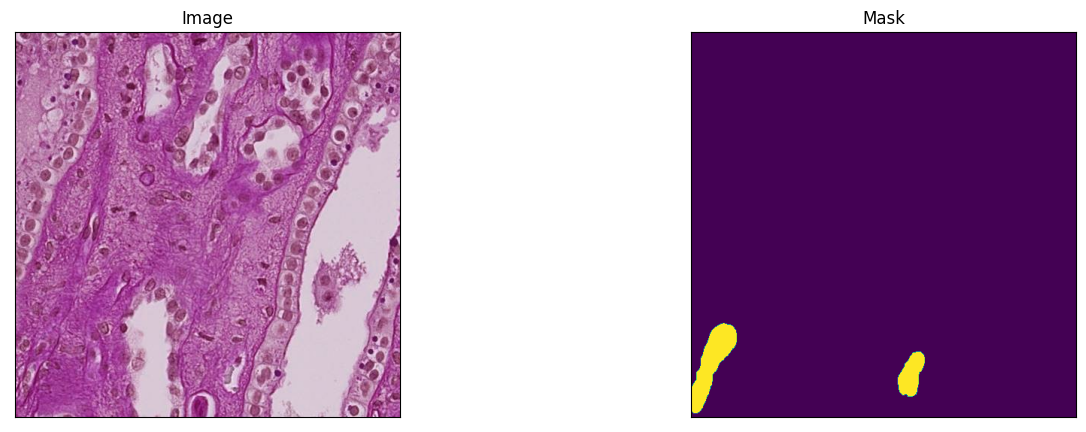

In [27]:
dataset = HubMapDataset(x_train_dir, y_train_dir, classes=['blood_vessel'])
print(len(dataset))
image, mask = dataset[0] # get some sample
visualize(
    image=image, 
    mask=mask.squeeze(),
)

In [28]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=512, min_width=352, always_apply=True, border_mode=0),
        albu.RandomCrop(height=512, width=352, always_apply=True),

        albu.GaussNoise(p=0.2),
        albu.Perspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightnessContrast(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.Sharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomBrightnessContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(512, 512)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

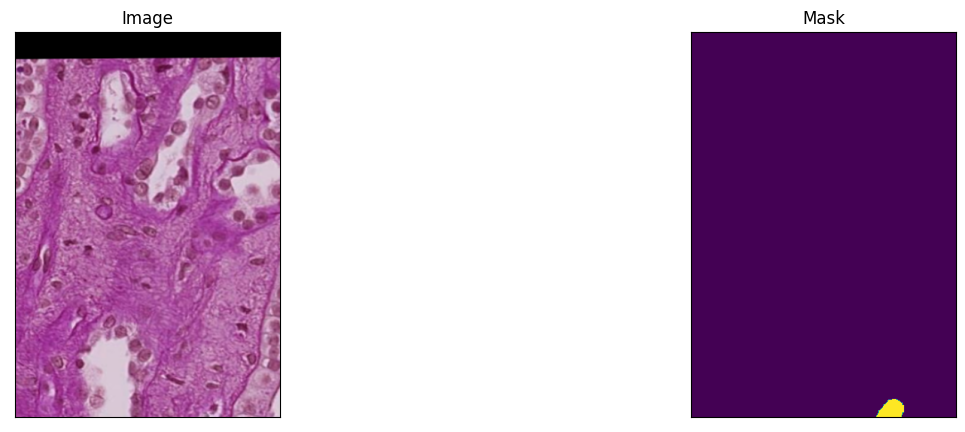

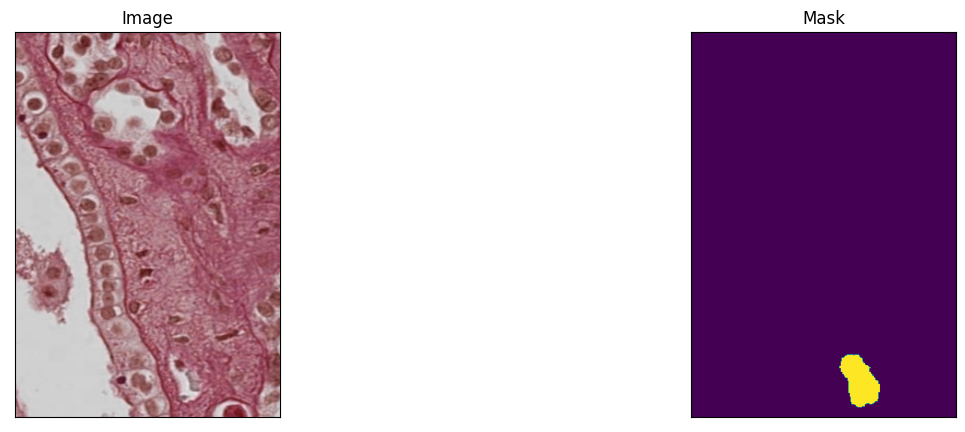

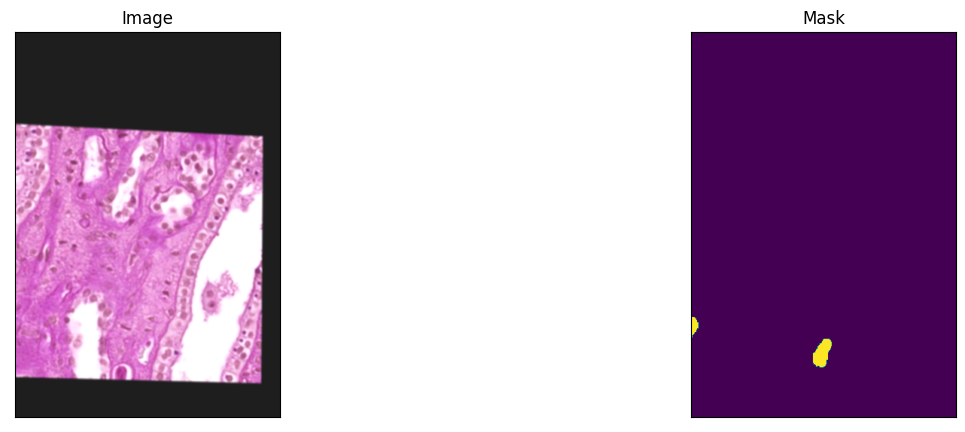

In [29]:
augmented_dataset = HubMapDataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    classes=['blood_vessel'],
)
# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[0]
    visualize(image=image, mask=mask.squeeze(-1))

In [30]:
CLASSES = ['blood_vessel']
ENCODER = 'efficientnet-b7'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid'

In [31]:
model = smp.Unet(
    encoder_name=ENCODER,        
    encoder_weights=ENCODER_WEIGHTS,     
    in_channels=3,                  
    classes=len(CLASSES)
)

In [32]:
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [33]:
train_dataset = HubMapDataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = HubMapDataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=2)

In [34]:
from torchmetrics import Metric
class IoUScore(Metric):
    def __init__(self, threshold=0.5, dist_sync_on_step=False):
        super().__init__(dist_sync_on_step=dist_sync_on_step)
        self.threshold = threshold
        self.add_state("intersection", default=torch.tensor(0), dist_reduce_fx="sum")
        self.add_state("union", default=torch.tensor(0), dist_reduce_fx="sum")

    def update(self, preds: torch.Tensor, target: torch.Tensor):
        print(f' Preds min: {torch.min(preds)}, Preds max: {torch.max(preds)}')
        preds = (preds > self.threshold).int()
        intersection = torch.logical_and(preds, target).sum()
        union = torch.logical_or(preds, target).sum()

        self.intersection += intersection
        self.union += union

    def compute(self):
        iou = self.intersection.float() / self.union.float()
        return iou

In [35]:
import torchmetrics
loss = smp.losses.DiceLoss(mode='binary', from_logits=True)
metrics = [
    IoUScore(threshold=0.5).to(DEVICE),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [36]:
from tqdm import tqdm
# Training loop
def train_epoch(model, loss_fn, metrics, optimizer, device, dataloader):
    model.train()
    num_batches = len(dataloader)
    total_loss = 0
    print(f'Processing a total of {num_batches} batches in training')
    # Iterate over the training dataset
    for batch_idx, (inputs, targets) in tqdm(enumerate(dataloader)):
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        print(f'Outputs min: {torch.min(outputs)}, Outputs max: {torch.max(outputs)}')
        loss = loss_fn(outputs, targets)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Compute metrics
        for metric in metrics:
            metric.update(torch.sigmoid(outputs), targets)
        total_loss += loss

    # Get the metric values
    metric_values = [float(total_loss)/num_batches] + [metric.compute() for metric in metrics]
    return metric_values

# Validation loop
def valid_epoch(model, loss_fn, metrics, device, dataloader):
    model.eval()
    num_batches = len(dataloader)
    total_loss = 0
    print(f'Processing a total of {num_batches} batches in validation')
    # Disable gradient calculation
    with torch.no_grad():
        # Iterate over the validation dataset
        for batch_idx, (inputs, targets) in tqdm(enumerate(dataloader)):
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)

            # Compute metrics
            for metric in metrics:
                metric.update(torch.sigmoid(outputs), targets)
            total_loss += loss

    # Get the metric values
    metric_values = [float(total_loss)/num_batches] + [metric.compute() for metric in metrics]
    return metric_values

In [15]:
max_iou = 0
num_epochs = 50
if os.path.exists('./models/model_stats.txt'):
  os.remove('./models/model_stats.txt')
fp = open('./models/model_stats.txt', 'a')
for epoch in range(num_epochs):
    # Training
    train_metrics = train_epoch(model, loss, metrics, optimizer, DEVICE, train_loader)
    print(f'=========Finished Training Epoch {epoch}==========')
    # Validation
    valid_metrics = valid_epoch(model, loss, metrics, DEVICE, valid_loader)
    print(f'=========Finished Validation Epoch {epoch}=========')
    
    cur_validation_iou = valid_metrics[1]
    if cur_validation_iou > max_iou:
      print(f'Saving model with IoU: {cur_validation_iou}...')
      torch.save(model, './models/best_model.pth')
      with open('./models/best_model.txt', 'w') as f:
        f.write(f"Epoch {epoch}: Train Loss={train_metrics[0]}, Validation Loss={valid_metrics[0]}, Train IoU={train_metrics[1]}, Validation IoU={valid_metrics[1]}")
      max_iou = cur_validation_iou
    # Print or log the metrics for each epoch
    print(f"Epoch {epoch}: Train Loss={train_metrics[0]}, Validation Loss={valid_metrics[0]}, Train IoU={train_metrics[1]}, Validation IoU={valid_metrics[1]}")
    fp.write(f"Epoch {epoch}: Train Loss={train_metrics[0]}, Validation Loss={valid_metrics[0]}, Train IoU={train_metrics[1]}, Validation IoU={valid_metrics[1]}\n")
    fp.flush()
fp.close()

Processing a total of 1 batches in training


0it [00:00, ?it/s]

Outputs min: -6.625366687774658, Outputs max: 2.866272449493408


1it [00:04,  4.50s/it]

 Preds min: 0.0013245372101664543, Preds max: 0.9461537599563599
=========Finished Training Epoch 0==========
Processing a total of 1 batches in validation



1it [00:01,  1.82s/it]

 Preds min: 0.001987067749723792, Preds max: 0.9644445776939392
=========Finished Validation Epoch 0=========
Saving model with IoU: 0.22588789463043213...


Epoch 0: Train Loss=0.46029430627822876, Validation Loss=0.9418503046035767, Train IoU=0.33640870451927185, Validation IoU=0.22588789463043213
Processing a total of 1 batches in training


0it [00:00, ?it/s]

Outputs min: -7.786434650421143, Outputs max: 3.1702516078948975


1it [00:06,  6.93s/it]

 Preds min: 0.00041515863267704844, Preds max: 0.9596993327140808
=========Finished Training Epoch 1==========
Processing a total of 1 batches in validation



1it [00:01,  1.88s/it]

 Preds min: 0.00724991038441658, Preds max: 0.9566624164581299
=========Finished Validation Epoch 1=========
Epoch 1: Train Loss=0.47463560104370117, Validation Loss=0.9454658031463623, Train IoU=0.2785840630531311, Validation IoU=0.22404421865940094
Processing a total of 1 batches in training



0it [00:00, ?it/s]

Outputs min: -7.627684593200684, Outputs max: 3.521700859069824


1it [00:06,  6.11s/it]

 Preds min: 0.000486549804918468, Preds max: 0.9712989926338196
=========Finished Training Epoch 2==========
Processing a total of 1 batches in validation



1it [00:02,  2.02s/it]

 Preds min: 0.007110658101737499, Preds max: 0.9563778042793274
=========Finished Validation Epoch 2=========
Saving model with IoU: 0.23536454141139984...


Epoch 2: Train Loss=0.4156477451324463, Validation Loss=0.9476128220558167, Train IoU=0.273630291223526, Validation IoU=0.23536454141139984
Processing a total of 1 batches in training


0it [00:00, ?it/s]

Outputs min: -8.409228324890137, Outputs max: 3.58420729637146


0it [00:07, ?it/s]
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9265a8acb0>
Traceback (most recent call last):
  File "/home/rmahajani31/anaconda3/envs/HubMapEnv/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/rmahajani31/anaconda3/envs/HubMapEnv/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1430, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/rmahajani31/anaconda3/envs/HubMapEnv/lib/python3.7/multiprocessing/process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "/home/rmahajani31/anaconda3/envs/HubMapEnv/lib/python3.7/multiprocessing/popen_fork.py", line 45, in wait
    if not wait([self.sentinel], timeout):
  File "/home/rmahajani31/anaconda3/envs/HubMapEnv/lib/python3.7/multiprocessing/connection.py", line 921, in wait
    ready = selector.select(timeout)
  File "/home/rmahajani31/anaconda3/envs

Traceback (most recent call last):
  File "/home/rmahajani31/anaconda3/envs/HubMapEnv/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_6888/210561082.py", line 8, in <module>
    train_metrics = train_epoch(model, loss, metrics, optimizer, DEVICE, train_loader)
  File "/tmp/ipykernel_6888/1041386869.py", line 22, in train_epoch
    optimizer.step()
  File "/home/rmahajani31/anaconda3/envs/HubMapEnv/lib/python3.7/site-packages/torch/optim/optimizer.py", line 140, in wrapper
    out = func(*args, **kwargs)
  File "/home/rmahajani31/anaconda3/envs/HubMapEnv/lib/python3.7/site-packages/torch/optim/optimizer.py", line 23, in _use_grad
    ret = func(self, *args, **kwargs)
  File "/home/rmahajani31/anaconda3/envs/HubMapEnv/lib/python3.7/site-packages/torch/optim/adam.py", line 252, in step
    found_inf=found_inf)
  File "/home/rmahajani31/anaconda3/envs/HubMapEnv/lib/python3.7/s

TypeError: object of type 'NoneType' has no len()

In [38]:
# Inference
DEVICE = 'cpu'
best_model = torch.load('./models/best_model.pth', map_location=torch.device('cpu'))
best_model = best_model.to(DEVICE)

In [39]:
CLASSES = ['blood_vessel']
test_dataset = HubMapDataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_loader = DataLoader(test_dataset)

In [40]:
valid_metrics = valid_epoch(best_model, loss, metrics, DEVICE, test_loader)
print(f'Test Loss: {valid_metrics[0]}, Test IoU: {valid_metrics[1]}')

Processing a total of 327 batches in validation


1it [00:01,  1.26s/it]

 Preds min: 3.327333669887419e-15, Preds max: 1.0


2it [00:02,  1.23s/it]

 Preds min: 1.030312327018586e-14, Preds max: 1.0


3it [00:03,  1.23s/it]

 Preds min: 1.1904249287708613e-12, Preds max: 1.0


4it [00:05,  1.26s/it]

 Preds min: 3.741477180158048e-12, Preds max: 1.0


5it [00:06,  1.26s/it]

 Preds min: 6.704811944362177e-13, Preds max: 1.0


6it [00:07,  1.24s/it]

 Preds min: 5.699573571351507e-14, Preds max: 1.0


7it [00:08,  1.29s/it]

 Preds min: 4.664308002333417e-12, Preds max: 1.0


8it [00:10,  1.29s/it]

 Preds min: 3.1521649439952837e-13, Preds max: 1.0


9it [00:11,  1.33s/it]

 Preds min: 1.5759403059877747e-13, Preds max: 1.0


10it [00:12,  1.34s/it]

 Preds min: 3.6558530691393944e-15, Preds max: 1.0


11it [00:14,  1.33s/it]

 Preds min: 8.009954868435851e-14, Preds max: 1.0


12it [00:15,  1.32s/it]

 Preds min: 2.929547012961442e-12, Preds max: 1.0


13it [00:16,  1.32s/it]

 Preds min: 2.2388145157203887e-11, Preds max: 1.0


14it [00:18,  1.30s/it]

 Preds min: 3.9920983185837144e-12, Preds max: 1.0


15it [00:19,  1.30s/it]

 Preds min: 2.3369231896830378e-11, Preds max: 1.0


16it [00:20,  1.28s/it]

 Preds min: 3.310973890890967e-12, Preds max: 1.0


17it [00:21,  1.28s/it]

 Preds min: 1.3007338262038814e-10, Preds max: 1.0


18it [00:23,  1.28s/it]

 Preds min: 7.013771074343422e-12, Preds max: 1.0


19it [00:24,  1.38s/it]

 Preds min: 2.9999072670428006e-11, Preds max: 1.0


20it [00:26,  1.40s/it]

 Preds min: 1.1454838542545448e-13, Preds max: 1.0


21it [00:27,  1.37s/it]

 Preds min: 4.4930769174666985e-13, Preds max: 1.0


22it [00:28,  1.33s/it]

 Preds min: 6.855673255652672e-13, Preds max: 1.0


23it [00:30,  1.31s/it]

 Preds min: 4.050978302805319e-11, Preds max: 1.0


24it [00:31,  1.30s/it]

 Preds min: 1.1611089693885912e-12, Preds max: 1.0


25it [00:32,  1.32s/it]

 Preds min: 9.059730504863694e-13, Preds max: 1.0


26it [00:34,  1.34s/it]

 Preds min: 5.993732593578827e-11, Preds max: 1.0


27it [00:35,  1.32s/it]

 Preds min: 3.132990015423248e-13, Preds max: 1.0


28it [00:36,  1.35s/it]

 Preds min: 2.4212874543891316e-13, Preds max: 1.0


29it [00:38,  1.37s/it]

 Preds min: 3.0645767173931304e-11, Preds max: 1.0


30it [00:39,  1.39s/it]

 Preds min: 7.789501330198942e-14, Preds max: 1.0


31it [00:41,  1.40s/it]

 Preds min: 4.530750774556225e-14, Preds max: 1.0


32it [00:42,  1.39s/it]

 Preds min: 6.453272811957067e-12, Preds max: 1.0


33it [00:43,  1.39s/it]

 Preds min: 2.188482685003268e-12, Preds max: 1.0


34it [00:45,  1.39s/it]

 Preds min: 7.623290887437406e-11, Preds max: 1.0


35it [00:46,  1.37s/it]

 Preds min: 3.3609785961286054e-12, Preds max: 1.0


36it [00:47,  1.37s/it]

 Preds min: 8.989785305058007e-11, Preds max: 1.0


37it [00:49,  1.34s/it]

 Preds min: 2.1058899253318525e-14, Preds max: 1.0


38it [00:50,  1.37s/it]

 Preds min: 1.5022665403319202e-11, Preds max: 1.0


39it [00:51,  1.36s/it]

 Preds min: 2.7407218161634717e-10, Preds max: 0.04290100932121277


40it [00:53,  1.38s/it]

 Preds min: 4.782226047453375e-13, Preds max: 1.0


41it [00:54,  1.36s/it]

 Preds min: 2.513314383001397e-11, Preds max: 1.0


42it [00:56,  1.38s/it]

 Preds min: 1.3206901718076924e-11, Preds max: 1.0


43it [00:57,  1.36s/it]

 Preds min: 1.6322311341063211e-12, Preds max: 1.0


44it [00:59,  1.42s/it]

 Preds min: 2.878844081524723e-14, Preds max: 1.0


45it [01:00,  1.41s/it]

 Preds min: 7.161798064314606e-12, Preds max: 1.0


46it [01:01,  1.44s/it]

 Preds min: 3.445724066318545e-13, Preds max: 1.0


47it [01:03,  1.44s/it]

 Preds min: 6.7952843872676194e-12, Preds max: 1.0


48it [01:04,  1.40s/it]

 Preds min: 3.3660596011897415e-12, Preds max: 1.0


49it [01:05,  1.38s/it]

 Preds min: 1.222382004645306e-12, Preds max: 1.0


50it [01:07,  1.36s/it]

 Preds min: 4.15927500774238e-11, Preds max: 1.0


51it [01:08,  1.35s/it]

 Preds min: 5.2864569682507453e-14, Preds max: 1.0


52it [01:10,  1.38s/it]

 Preds min: 1.3596156145379013e-10, Preds max: 1.0


53it [01:11,  1.37s/it]

 Preds min: 2.1514693238772198e-12, Preds max: 1.0


54it [01:12,  1.34s/it]

 Preds min: 2.408031551937029e-10, Preds max: 1.0


55it [01:14,  1.34s/it]

 Preds min: 1.1015691137039596e-10, Preds max: 1.0


56it [01:15,  1.38s/it]

 Preds min: 1.372210613366509e-12, Preds max: 1.0


57it [01:16,  1.35s/it]

 Preds min: 4.4006278791331246e-14, Preds max: 1.0


58it [01:18,  1.34s/it]

 Preds min: 9.470745178765186e-14, Preds max: 1.0


59it [01:19,  1.33s/it]

 Preds min: 2.6258485403413134e-12, Preds max: 1.0


60it [01:20,  1.31s/it]

 Preds min: 5.101664091178293e-10, Preds max: 1.0


61it [01:21,  1.30s/it]

 Preds min: 1.9354982894181916e-10, Preds max: 1.0


62it [01:23,  1.29s/it]

 Preds min: 1.4864821748722737e-14, Preds max: 1.0


63it [01:24,  1.35s/it]

 Preds min: 5.870167633231782e-13, Preds max: 1.0


64it [01:26,  1.34s/it]

 Preds min: 5.657357720310896e-13, Preds max: 1.0


65it [01:27,  1.37s/it]

 Preds min: 4.600153808223539e-13, Preds max: 1.0


66it [01:29,  1.44s/it]

 Preds min: 3.855884778136698e-10, Preds max: 1.0


67it [01:30,  1.46s/it]

 Preds min: 7.357989911804808e-11, Preds max: 1.0


68it [01:32,  1.50s/it]

 Preds min: 1.2485883854607138e-11, Preds max: 1.0


69it [01:33,  1.46s/it]

 Preds min: 6.921097028822487e-11, Preds max: 1.0


70it [01:34,  1.44s/it]

 Preds min: 2.9472587564916e-11, Preds max: 1.0


71it [01:36,  1.42s/it]

 Preds min: 9.849233928438395e-11, Preds max: 1.0


72it [01:37,  1.37s/it]

 Preds min: 3.1474053918678635e-10, Preds max: 1.0


73it [01:38,  1.35s/it]

 Preds min: 1.3255235797871023e-10, Preds max: 1.0


74it [01:40,  1.38s/it]

 Preds min: 6.3969983823963794e-12, Preds max: 1.0


75it [01:41,  1.39s/it]

 Preds min: 7.172426308476101e-14, Preds max: 1.0


76it [01:43,  1.37s/it]

 Preds min: 2.442232527322119e-10, Preds max: 1.0


77it [01:44,  1.33s/it]

 Preds min: 2.7396737222601386e-12, Preds max: 1.0


78it [01:45,  1.33s/it]

 Preds min: 3.127746672770826e-10, Preds max: 1.0


79it [01:47,  1.38s/it]

 Preds min: 7.728850198729376e-11, Preds max: 1.0


80it [01:48,  1.35s/it]

 Preds min: 4.015464447493927e-13, Preds max: 1.0


81it [01:49,  1.37s/it]

 Preds min: 1.0133922780791726e-12, Preds max: 1.0


82it [01:51,  1.39s/it]

 Preds min: 3.683007458038512e-12, Preds max: 1.0


83it [01:52,  1.37s/it]

 Preds min: 9.545735377277861e-14, Preds max: 1.0


84it [01:53,  1.36s/it]

 Preds min: 4.4026997325641304e-11, Preds max: 1.0


85it [01:55,  1.37s/it]

 Preds min: 1.4332170162039554e-13, Preds max: 1.0


86it [01:56,  1.39s/it]

 Preds min: 4.288700037463622e-12, Preds max: 1.0


87it [01:58,  1.43s/it]

 Preds min: 3.391601235969155e-11, Preds max: 1.0


88it [01:59,  1.41s/it]

 Preds min: 8.234143401841809e-12, Preds max: 1.0


89it [02:01,  1.42s/it]

 Preds min: 1.5803659379406976e-12, Preds max: 1.0


90it [02:02,  1.38s/it]

 Preds min: 7.928930081946284e-12, Preds max: 1.0


91it [02:03,  1.39s/it]

 Preds min: 1.482169096657382e-12, Preds max: 1.0


92it [02:05,  1.39s/it]

 Preds min: 4.54396416327274e-11, Preds max: 1.0


93it [02:06,  1.41s/it]

 Preds min: 1.0909674205694664e-11, Preds max: 1.0


94it [02:07,  1.40s/it]

 Preds min: 1.2676020172755487e-12, Preds max: 1.0


95it [02:09,  1.43s/it]

 Preds min: 3.326110681366526e-14, Preds max: 1.0


96it [02:11,  1.56s/it]

 Preds min: 7.036677420217338e-14, Preds max: 1.0


97it [02:13,  1.60s/it]

 Preds min: 2.718859026806797e-10, Preds max: 1.0


98it [02:14,  1.57s/it]

 Preds min: 1.0543436512310683e-13, Preds max: 1.0


99it [02:15,  1.51s/it]

 Preds min: 9.16829004209141e-13, Preds max: 1.0


100it [02:17,  1.47s/it]

 Preds min: 1.3747405720309497e-13, Preds max: 1.0


101it [02:18,  1.43s/it]

 Preds min: 1.644238402116055e-13, Preds max: 1.0


102it [02:19,  1.41s/it]

 Preds min: 1.2339753784756935e-12, Preds max: 1.0


103it [02:21,  1.40s/it]

 Preds min: 1.4164770701860507e-12, Preds max: 1.0


104it [02:22,  1.41s/it]

 Preds min: 2.2823322398668466e-10, Preds max: 1.0


105it [02:24,  1.41s/it]

 Preds min: 6.198870843715509e-12, Preds max: 1.0


106it [02:25,  1.40s/it]

 Preds min: 9.839398989585496e-14, Preds max: 1.0


107it [02:26,  1.39s/it]

 Preds min: 7.190582764632358e-12, Preds max: 1.0


108it [02:28,  1.38s/it]

 Preds min: 5.046162191444173e-14, Preds max: 1.0


109it [02:29,  1.37s/it]

 Preds min: 6.368146461543933e-12, Preds max: 1.0


110it [02:31,  1.40s/it]

 Preds min: 1.864334932906355e-14, Preds max: 1.0


111it [02:32,  1.47s/it]

 Preds min: 7.438649002322606e-11, Preds max: 1.0


112it [02:34,  1.50s/it]

 Preds min: 1.1833922730630775e-10, Preds max: 1.0


113it [02:35,  1.49s/it]

 Preds min: 1.91149548446623e-12, Preds max: 1.0


114it [02:37,  1.50s/it]

 Preds min: 1.3778256964178115e-12, Preds max: 1.0


115it [02:38,  1.48s/it]

 Preds min: 8.971344175358331e-13, Preds max: 1.0


116it [02:40,  1.47s/it]

 Preds min: 4.5814900484497656e-11, Preds max: 1.0


117it [02:41,  1.51s/it]

 Preds min: 4.5486769732761e-13, Preds max: 1.0


118it [02:43,  1.47s/it]

 Preds min: 1.621843528617009e-13, Preds max: 1.0


119it [02:44,  1.44s/it]

 Preds min: 1.8163285112060557e-11, Preds max: 1.0


120it [02:46,  1.49s/it]

 Preds min: 9.902844516629372e-11, Preds max: 1.0


121it [02:47,  1.52s/it]

 Preds min: 1.3787893049510558e-10, Preds max: 1.0


122it [02:49,  1.56s/it]

 Preds min: 4.537812400146057e-12, Preds max: 1.0


123it [02:50,  1.53s/it]

 Preds min: 4.045273838126917e-10, Preds max: 1.0


124it [02:52,  1.52s/it]

 Preds min: 4.4645723749903166e-12, Preds max: 1.0


125it [02:53,  1.52s/it]

 Preds min: 2.144663163424279e-13, Preds max: 1.0


126it [02:55,  1.53s/it]

 Preds min: 8.012904575971369e-14, Preds max: 1.0


127it [02:56,  1.49s/it]

 Preds min: 2.727889312006959e-12, Preds max: 1.0


128it [02:58,  1.51s/it]

 Preds min: 1.3921460555524345e-12, Preds max: 1.0


129it [02:59,  1.48s/it]

 Preds min: 1.056083779454875e-11, Preds max: 1.0


130it [03:01,  1.47s/it]

 Preds min: 7.674058362784706e-15, Preds max: 1.0


131it [03:02,  1.44s/it]

 Preds min: 9.217349106194206e-13, Preds max: 1.0


132it [03:04,  1.43s/it]

 Preds min: 2.921654029819365e-10, Preds max: 0.1624757945537567


133it [03:05,  1.41s/it]

 Preds min: 8.164950920236391e-13, Preds max: 1.0


134it [03:06,  1.42s/it]

 Preds min: 3.32943568548405e-11, Preds max: 1.0


135it [03:08,  1.42s/it]

 Preds min: 1.8414947572462786e-13, Preds max: 1.0


136it [03:09,  1.41s/it]

 Preds min: 4.769205169674606e-11, Preds max: 1.0


137it [03:11,  1.42s/it]

 Preds min: 1.497584472881161e-13, Preds max: 1.0


138it [03:12,  1.49s/it]

 Preds min: 1.1859671231184699e-12, Preds max: 1.0


139it [03:14,  1.46s/it]

 Preds min: 3.164589770787707e-11, Preds max: 1.0


140it [03:15,  1.44s/it]

 Preds min: 5.5693248623978064e-11, Preds max: 1.0


141it [03:16,  1.44s/it]

 Preds min: 1.562869972326908e-11, Preds max: 1.0


142it [03:18,  1.41s/it]

 Preds min: 1.2351268011828731e-12, Preds max: 1.0


143it [03:19,  1.40s/it]

 Preds min: 9.779509016830112e-14, Preds max: 1.0


144it [03:21,  1.42s/it]

 Preds min: 5.373167882849472e-11, Preds max: 1.0


145it [03:22,  1.40s/it]

 Preds min: 5.047591623070136e-16, Preds max: 1.0


146it [03:23,  1.40s/it]

 Preds min: 5.773281852583523e-11, Preds max: 1.0


147it [03:25,  1.39s/it]

 Preds min: 2.0203137773844304e-11, Preds max: 1.0


148it [03:26,  1.41s/it]

 Preds min: 6.880346986593011e-11, Preds max: 1.0


149it [03:28,  1.44s/it]

 Preds min: 6.789084268724044e-14, Preds max: 1.0


150it [03:29,  1.43s/it]

 Preds min: 5.549443196639636e-11, Preds max: 1.0


151it [03:31,  1.42s/it]

 Preds min: 6.25440740864569e-11, Preds max: 1.0


152it [03:32,  1.40s/it]

 Preds min: 4.542298395054933e-12, Preds max: 1.0


153it [03:33,  1.39s/it]

 Preds min: 6.422861781275532e-14, Preds max: 1.0


154it [03:35,  1.39s/it]

 Preds min: 3.391862799743267e-13, Preds max: 1.0


155it [03:36,  1.40s/it]

 Preds min: 4.444267003023139e-12, Preds max: 1.0


156it [03:37,  1.41s/it]

 Preds min: 2.3152557648842276e-10, Preds max: 0.006900334265083075


157it [03:39,  1.41s/it]

 Preds min: 2.823823293252037e-11, Preds max: 1.0


158it [03:40,  1.44s/it]

 Preds min: 3.256292804842964e-12, Preds max: 1.0


159it [03:42,  1.53s/it]

 Preds min: 6.925325113718572e-14, Preds max: 1.0


160it [03:44,  1.53s/it]

 Preds min: 8.416071659023139e-13, Preds max: 1.0


161it [03:45,  1.50s/it]

 Preds min: 1.667714716324653e-10, Preds max: 1.0


162it [03:47,  1.50s/it]

 Preds min: 1.3578475149822467e-11, Preds max: 1.0


163it [03:48,  1.47s/it]

 Preds min: 1.826795659187752e-12, Preds max: 1.0


164it [03:49,  1.47s/it]

 Preds min: 9.1748717997997e-12, Preds max: 1.0


165it [03:51,  1.47s/it]

 Preds min: 5.5764358408705306e-11, Preds max: 1.0


166it [03:52,  1.46s/it]

 Preds min: 2.7013886461958736e-13, Preds max: 1.0


167it [03:54,  1.46s/it]

 Preds min: 2.939277171805886e-14, Preds max: 1.0


168it [03:55,  1.49s/it]

 Preds min: 3.685923961882498e-12, Preds max: 1.0


169it [03:57,  1.50s/it]

 Preds min: 1.0969386206663434e-12, Preds max: 1.0


170it [03:58,  1.52s/it]

 Preds min: 1.3953393128429692e-11, Preds max: 1.0


171it [04:00,  1.57s/it]

 Preds min: 6.88291561400556e-16, Preds max: 1.0


172it [04:02,  1.65s/it]

 Preds min: 1.4755096016533242e-12, Preds max: 1.0


173it [04:03,  1.59s/it]

 Preds min: 1.3446690592597288e-12, Preds max: 1.0


174it [04:05,  1.53s/it]

 Preds min: 3.64453823023525e-12, Preds max: 1.0


175it [04:06,  1.49s/it]

 Preds min: 6.116478851181384e-13, Preds max: 1.0


176it [04:08,  1.45s/it]

 Preds min: 8.587816222038747e-12, Preds max: 1.0


177it [04:09,  1.43s/it]

 Preds min: 4.01617676832125e-13, Preds max: 1.0


178it [04:10,  1.40s/it]

 Preds min: 2.8938018648005936e-10, Preds max: 1.0


179it [04:12,  1.42s/it]

 Preds min: 3.654499446115178e-12, Preds max: 1.0


180it [04:13,  1.41s/it]

 Preds min: 3.11801062399808e-12, Preds max: 1.0


181it [04:15,  1.39s/it]

 Preds min: 7.653854112998904e-12, Preds max: 1.0


182it [04:16,  1.39s/it]

 Preds min: 5.307626625532247e-13, Preds max: 1.0


183it [04:17,  1.39s/it]

 Preds min: 5.226026859525557e-13, Preds max: 1.0


184it [04:19,  1.38s/it]

 Preds min: 1.28178665598222e-11, Preds max: 1.0


185it [04:20,  1.36s/it]

 Preds min: 1.4260768781138022e-11, Preds max: 1.0


186it [04:21,  1.37s/it]

 Preds min: 2.5187551697114507e-12, Preds max: 1.0


187it [04:23,  1.36s/it]

 Preds min: 2.1878793264942797e-14, Preds max: 1.0


188it [04:24,  1.36s/it]

 Preds min: 2.331431217788421e-13, Preds max: 1.0


189it [04:25,  1.36s/it]

 Preds min: 9.124323611118049e-14, Preds max: 1.0


190it [04:27,  1.35s/it]

 Preds min: 1.9398916500934504e-11, Preds max: 1.0


191it [04:28,  1.38s/it]

 Preds min: 9.34453686304848e-13, Preds max: 1.0


192it [04:30,  1.38s/it]

 Preds min: 1.2201947351825337e-12, Preds max: 1.0


193it [04:31,  1.37s/it]

 Preds min: 7.591014405602947e-13, Preds max: 1.0


194it [04:32,  1.36s/it]

 Preds min: 1.2699608346270624e-13, Preds max: 1.0


195it [04:34,  1.36s/it]

 Preds min: 9.672812897876248e-12, Preds max: 1.0


196it [04:35,  1.35s/it]

 Preds min: 3.638745121187226e-12, Preds max: 1.0


197it [04:36,  1.37s/it]

 Preds min: 1.8274180779709326e-10, Preds max: 1.0


198it [04:38,  1.37s/it]

 Preds min: 1.8004585669584294e-11, Preds max: 1.0


199it [04:39,  1.36s/it]

 Preds min: 1.9606649745602944e-13, Preds max: 1.0


200it [04:41,  1.41s/it]

 Preds min: 8.555359112122352e-13, Preds max: 1.0


201it [04:42,  1.43s/it]

 Preds min: 1.1732400641284446e-11, Preds max: 1.0


202it [04:44,  1.45s/it]

 Preds min: 1.6057942193829777e-13, Preds max: 1.0


203it [04:45,  1.45s/it]

 Preds min: 1.6421246307185555e-11, Preds max: 1.0


204it [04:46,  1.43s/it]

 Preds min: 1.0182223987575956e-12, Preds max: 1.0


205it [04:48,  1.45s/it]

 Preds min: 8.817672286776101e-11, Preds max: 1.0


206it [04:49,  1.43s/it]

 Preds min: 3.189823752358656e-11, Preds max: 1.0


207it [04:51,  1.41s/it]

 Preds min: 7.534304430345529e-11, Preds max: 1.0


208it [04:52,  1.44s/it]

 Preds min: 4.838950854596513e-12, Preds max: 1.0


209it [04:54,  1.44s/it]

 Preds min: 2.712481628197594e-11, Preds max: 1.0


210it [04:55,  1.42s/it]

 Preds min: 1.9783656592282928e-13, Preds max: 1.0


211it [04:56,  1.42s/it]

 Preds min: 1.9729732441981646e-13, Preds max: 1.0


212it [04:58,  1.43s/it]

 Preds min: 1.1266288466385554e-12, Preds max: 1.0


213it [04:59,  1.43s/it]

 Preds min: 7.309995664339652e-11, Preds max: 1.0


214it [05:01,  1.45s/it]

 Preds min: 1.8244644683917954e-10, Preds max: 1.0


215it [05:02,  1.41s/it]

 Preds min: 1.321658615882626e-10, Preds max: 1.0


216it [05:03,  1.40s/it]

 Preds min: 2.4553711841512893e-10, Preds max: 1.0


217it [05:05,  1.39s/it]

 Preds min: 1.590382547878022e-10, Preds max: 1.0


218it [05:06,  1.41s/it]

 Preds min: 1.5544959763857946e-10, Preds max: 1.0


219it [05:08,  1.41s/it]

 Preds min: 4.765377328852516e-11, Preds max: 1.0


220it [05:09,  1.40s/it]

 Preds min: 3.3921043057771882e-12, Preds max: 1.0


221it [05:10,  1.40s/it]

 Preds min: 3.8099823860063275e-13, Preds max: 1.0


222it [05:12,  1.41s/it]

 Preds min: 5.74080659312276e-13, Preds max: 1.0


223it [05:13,  1.41s/it]

 Preds min: 1.8103354926246595e-10, Preds max: 0.37249651551246643


224it [05:15,  1.40s/it]

 Preds min: 2.1740178440707e-15, Preds max: 1.0


225it [05:16,  1.38s/it]

 Preds min: 5.4861371522052504e-12, Preds max: 1.0


226it [05:17,  1.39s/it]

 Preds min: 6.968345345192972e-11, Preds max: 1.0


227it [05:19,  1.38s/it]

 Preds min: 7.22519058471427e-11, Preds max: 1.0


228it [05:20,  1.38s/it]

 Preds min: 2.5998719843656204e-10, Preds max: 1.0


229it [05:22,  1.38s/it]

 Preds min: 2.359653618333457e-11, Preds max: 1.0


230it [05:23,  1.37s/it]

 Preds min: 8.232941373998229e-14, Preds max: 1.0


231it [05:24,  1.35s/it]

 Preds min: 1.2762275958255742e-10, Preds max: 1.0


232it [05:26,  1.36s/it]

 Preds min: 1.1691370094268905e-10, Preds max: 1.0


233it [05:27,  1.35s/it]

 Preds min: 4.4240259784548985e-13, Preds max: 1.0


234it [05:28,  1.35s/it]

 Preds min: 1.1485899748941032e-14, Preds max: 1.0


235it [05:30,  1.36s/it]

 Preds min: 1.0853796160448237e-12, Preds max: 1.0


236it [05:31,  1.40s/it]

 Preds min: 1.1112457525344621e-12, Preds max: 1.0


237it [05:33,  1.42s/it]

 Preds min: 1.4908430392979177e-11, Preds max: 1.0


238it [05:34,  1.40s/it]

 Preds min: 1.336169508370233e-10, Preds max: 1.0


239it [05:35,  1.38s/it]

 Preds min: 2.2085276316086144e-11, Preds max: 1.0


240it [05:37,  1.39s/it]

 Preds min: 2.8140701574530524e-11, Preds max: 1.0


241it [05:38,  1.39s/it]

 Preds min: 5.236772929358147e-13, Preds max: 1.0


242it [05:39,  1.39s/it]

 Preds min: 1.652476441273143e-12, Preds max: 1.0


243it [05:41,  1.38s/it]

 Preds min: 8.694683861776298e-12, Preds max: 1.0


244it [05:42,  1.40s/it]

 Preds min: 1.41893831753781e-11, Preds max: 1.0


245it [05:44,  1.41s/it]

 Preds min: 4.344038421078694e-13, Preds max: 1.0


246it [05:45,  1.39s/it]

 Preds min: 6.489075769777752e-13, Preds max: 1.0


247it [05:47,  1.41s/it]

 Preds min: 1.5978142203429413e-13, Preds max: 1.0


248it [05:48,  1.41s/it]

 Preds min: 1.3614138982820378e-10, Preds max: 1.0


249it [05:49,  1.41s/it]

 Preds min: 3.591862701365911e-12, Preds max: 1.0


250it [05:51,  1.45s/it]

 Preds min: 8.334626044881333e-11, Preds max: 1.0


251it [05:52,  1.42s/it]

 Preds min: 5.258774101943309e-13, Preds max: 1.0


252it [05:54,  1.41s/it]

 Preds min: 1.1849982106681978e-10, Preds max: 1.0


253it [05:55,  1.41s/it]

 Preds min: 1.0822694823664492e-10, Preds max: 1.0


254it [05:56,  1.40s/it]

 Preds min: 2.1956762796815354e-10, Preds max: 1.0


255it [05:58,  1.39s/it]

 Preds min: 6.8755873390558e-14, Preds max: 1.0


256it [05:59,  1.39s/it]

 Preds min: 1.91482819184019e-11, Preds max: 1.0


257it [06:01,  1.42s/it]

 Preds min: 1.666941697251855e-14, Preds max: 1.0


258it [06:02,  1.39s/it]

 Preds min: 2.335081563872854e-12, Preds max: 1.0


259it [06:03,  1.38s/it]

 Preds min: 1.265257667246774e-14, Preds max: 1.0


260it [06:05,  1.37s/it]

 Preds min: 1.6712525807704992e-10, Preds max: 1.0


261it [06:06,  1.36s/it]

 Preds min: 7.264212148472282e-11, Preds max: 1.0


262it [06:07,  1.36s/it]

 Preds min: 4.553642077124997e-13, Preds max: 1.0


263it [06:09,  1.36s/it]

 Preds min: 4.357964184832641e-13, Preds max: 1.0


264it [06:10,  1.37s/it]

 Preds min: 3.308199547635837e-10, Preds max: 1.0


265it [06:11,  1.37s/it]

 Preds min: 3.2168029091145245e-12, Preds max: 1.0


266it [06:13,  1.40s/it]

 Preds min: 3.0828294019132063e-13, Preds max: 1.0


267it [06:14,  1.39s/it]

 Preds min: 5.018689630542639e-11, Preds max: 1.0


268it [06:16,  1.37s/it]

 Preds min: 1.5533827479527473e-12, Preds max: 1.0


269it [06:17,  1.36s/it]

 Preds min: 5.215181064777141e-10, Preds max: 1.0


270it [06:18,  1.37s/it]

 Preds min: 1.8436625837114917e-10, Preds max: 1.0


271it [06:20,  1.36s/it]

 Preds min: 4.953821242104084e-10, Preds max: 1.0


272it [06:21,  1.36s/it]

 Preds min: 1.7815432289125521e-12, Preds max: 1.0


273it [06:22,  1.37s/it]

 Preds min: 8.103667476638821e-13, Preds max: 1.0


274it [06:24,  1.37s/it]

 Preds min: 4.2903671609341443e-13, Preds max: 1.0


275it [06:25,  1.38s/it]

 Preds min: 1.4983746882135662e-11, Preds max: 1.0


276it [06:27,  1.38s/it]

 Preds min: 2.515003760805712e-10, Preds max: 1.0


277it [06:28,  1.37s/it]

 Preds min: 2.596910533836372e-12, Preds max: 1.0


278it [06:29,  1.37s/it]

 Preds min: 9.066809802948939e-11, Preds max: 1.0


279it [06:31,  1.36s/it]

 Preds min: 1.7854440799089377e-13, Preds max: 1.0


280it [06:32,  1.40s/it]

 Preds min: 2.509109066350934e-11, Preds max: 1.0


281it [06:34,  1.40s/it]

 Preds min: 8.334693070259636e-14, Preds max: 1.0


282it [06:35,  1.37s/it]

 Preds min: 8.518864460420675e-14, Preds max: 1.0


283it [06:36,  1.37s/it]

 Preds min: 1.0966346510347599e-13, Preds max: 1.0


284it [06:38,  1.37s/it]

 Preds min: 1.0571700632955316e-11, Preds max: 1.0


285it [06:39,  1.37s/it]

 Preds min: 2.922506681102277e-10, Preds max: 1.0


286it [06:40,  1.38s/it]

 Preds min: 9.898825465912142e-14, Preds max: 1.0


287it [06:42,  1.38s/it]

 Preds min: 5.174778574396077e-12, Preds max: 1.0


288it [06:43,  1.41s/it]

 Preds min: 4.995575134114638e-12, Preds max: 1.0


289it [06:45,  1.41s/it]

 Preds min: 6.3625032298937276e-15, Preds max: 1.0


290it [06:46,  1.39s/it]

 Preds min: 2.376411567528436e-10, Preds max: 1.0


291it [06:47,  1.38s/it]

 Preds min: 4.097945940917391e-12, Preds max: 1.0


292it [06:49,  1.39s/it]

 Preds min: 7.128517394427991e-12, Preds max: 1.0


293it [06:50,  1.38s/it]

 Preds min: 3.961454862061453e-12, Preds max: 1.0


294it [06:51,  1.38s/it]

 Preds min: 1.1140103461015557e-13, Preds max: 1.0


295it [06:53,  1.38s/it]

 Preds min: 2.7509593561458878e-11, Preds max: 1.0


296it [06:54,  1.37s/it]

 Preds min: 6.999504871107315e-14, Preds max: 1.0


297it [06:56,  1.38s/it]

 Preds min: 1.606527411102121e-12, Preds max: 1.0


298it [06:57,  1.38s/it]

 Preds min: 2.0341020534608845e-11, Preds max: 1.0


299it [06:58,  1.38s/it]

 Preds min: 1.3466415482721317e-10, Preds max: 1.0


300it [07:00,  1.39s/it]

 Preds min: 2.861247480265283e-12, Preds max: 1.0


301it [07:01,  1.38s/it]

 Preds min: 8.178843019512883e-12, Preds max: 1.0


302it [07:03,  1.38s/it]

 Preds min: 2.0350218038478474e-11, Preds max: 1.0


303it [07:04,  1.37s/it]

 Preds min: 1.1752356032790345e-11, Preds max: 1.0


304it [07:05,  1.39s/it]

 Preds min: 3.566060988169362e-11, Preds max: 1.0


305it [07:07,  1.39s/it]

 Preds min: 1.2364385904017894e-10, Preds max: 1.0


306it [07:08,  1.38s/it]

 Preds min: 8.077823132612849e-12, Preds max: 1.0


307it [07:09,  1.37s/it]

 Preds min: 3.273412790827379e-11, Preds max: 1.0


308it [07:11,  1.37s/it]

 Preds min: 9.925218334922228e-14, Preds max: 1.0


309it [07:12,  1.35s/it]

 Preds min: 3.9965128645694237e-14, Preds max: 1.0


310it [07:14,  1.39s/it]

 Preds min: 4.2190524077861946e-13, Preds max: 1.0


311it [07:15,  1.39s/it]

 Preds min: 1.3172644919290377e-10, Preds max: 1.0


312it [07:16,  1.38s/it]

 Preds min: 5.321746732525612e-13, Preds max: 1.0


313it [07:18,  1.38s/it]

 Preds min: 4.670762474706658e-12, Preds max: 1.0


314it [07:19,  1.39s/it]

 Preds min: 1.6971020671673748e-13, Preds max: 1.0


315it [07:20,  1.39s/it]

 Preds min: 1.48895673568461e-10, Preds max: 1.0


316it [07:22,  1.38s/it]

 Preds min: 7.825252945625749e-11, Preds max: 1.0


317it [07:23,  1.37s/it]

 Preds min: 2.399837828459539e-10, Preds max: 1.0


318it [07:25,  1.37s/it]

 Preds min: 9.08736072502414e-11, Preds max: 1.0


319it [07:26,  1.36s/it]

 Preds min: 8.074202764718486e-12, Preds max: 1.0


320it [07:27,  1.37s/it]

 Preds min: 1.2337428821618257e-11, Preds max: 1.0


321it [07:29,  1.38s/it]

 Preds min: 2.5748073118059267e-10, Preds max: 1.0


322it [07:30,  1.40s/it]

 Preds min: 3.701336383655357e-13, Preds max: 1.0


323it [07:32,  1.40s/it]

 Preds min: 1.0260131265915021e-15, Preds max: 1.0


324it [07:33,  1.39s/it]

 Preds min: 1.582165232161259e-10, Preds max: 1.0


325it [07:34,  1.38s/it]

 Preds min: 3.9565711817957094e-11, Preds max: 1.0


326it [07:36,  1.36s/it]

 Preds min: 9.550469952639834e-14, Preds max: 1.0


327it [07:37,  1.40s/it]

 Preds min: 2.715018761569911e-14, Preds max: 1.0
Test Loss: 0.383111772916368, Test IoU: 0.5082769393920898


In [41]:
test_dataset_without_aug = HubMapDataset(
    x_test_dir, y_test_dir, 
    classes=CLASSES,
)
train_dataset_without_aug = HubMapDataset(
    x_train_dir, y_train_dir, 
    classes=CLASSES,
)

(3, 512, 352) (1, 512, 352)
torch.Size([1, 3, 512, 352])
torch.Size([1, 1, 512, 352])
(512, 352)


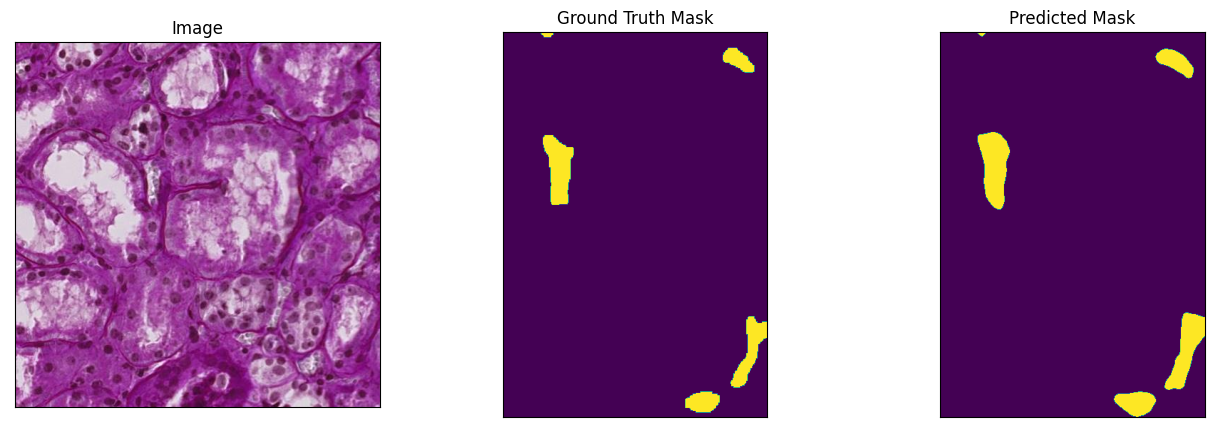

(3, 512, 352) (1, 512, 352)
torch.Size([1, 3, 512, 352])
torch.Size([1, 1, 512, 352])
(512, 352)


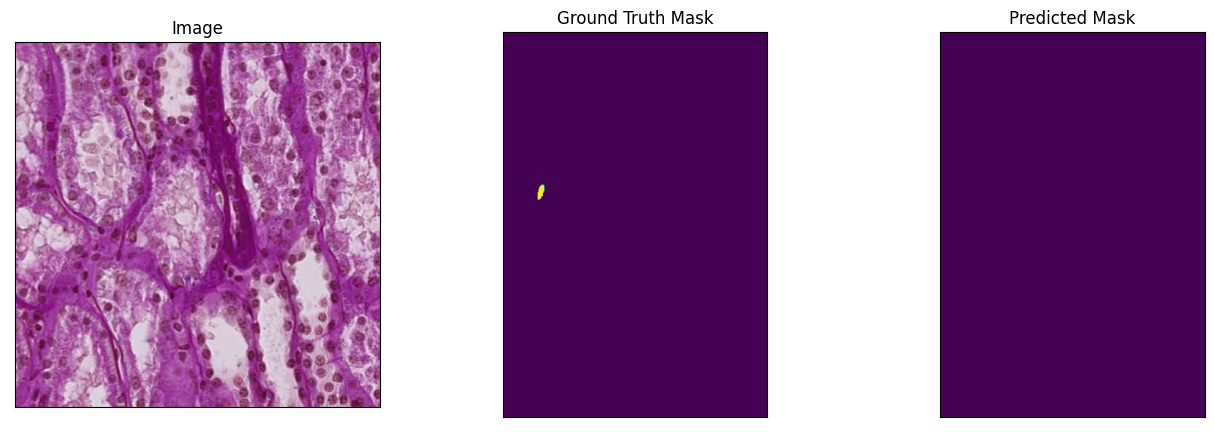

(3, 512, 352) (1, 512, 352)
torch.Size([1, 3, 512, 352])
torch.Size([1, 1, 512, 352])
(512, 352)


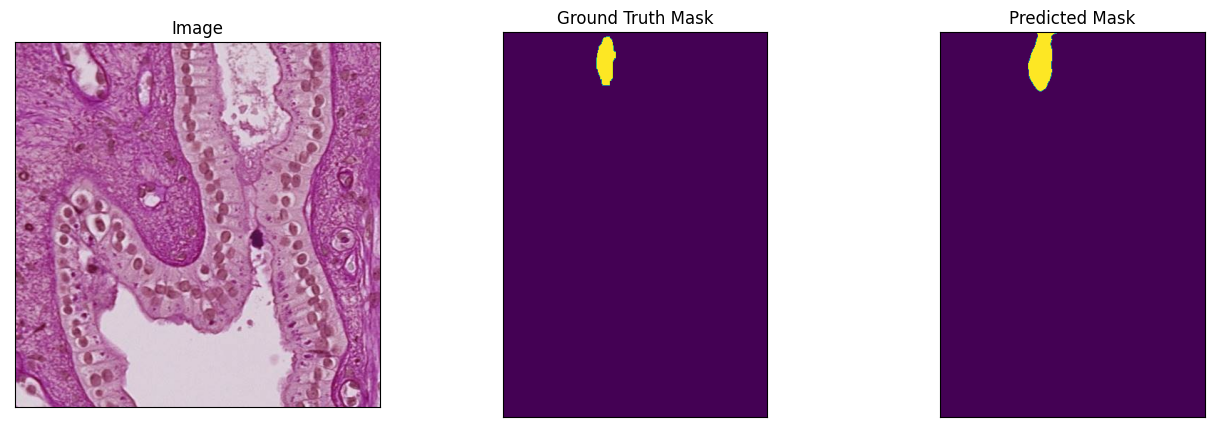

(3, 512, 352) (1, 512, 352)
torch.Size([1, 3, 512, 352])
torch.Size([1, 1, 512, 352])
(512, 352)


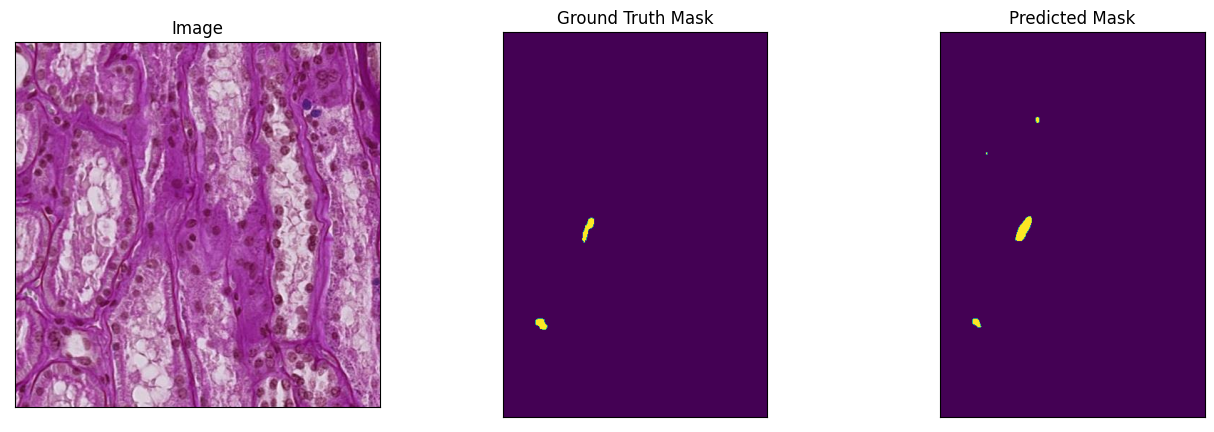

(3, 512, 352) (1, 512, 352)
torch.Size([1, 3, 512, 352])
torch.Size([1, 1, 512, 352])
(512, 352)


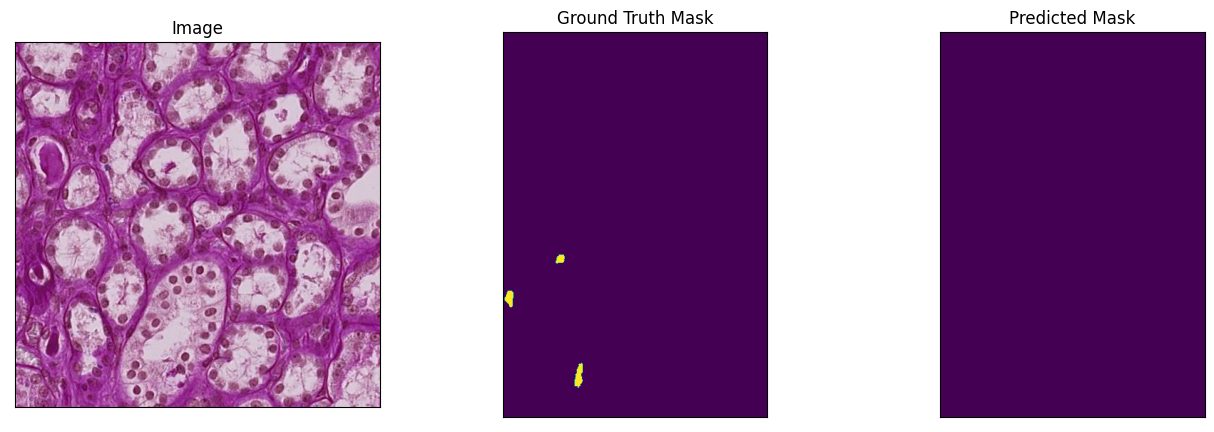

(3, 512, 352) (1, 512, 352)
torch.Size([1, 3, 512, 352])
torch.Size([1, 1, 512, 352])
(512, 352)


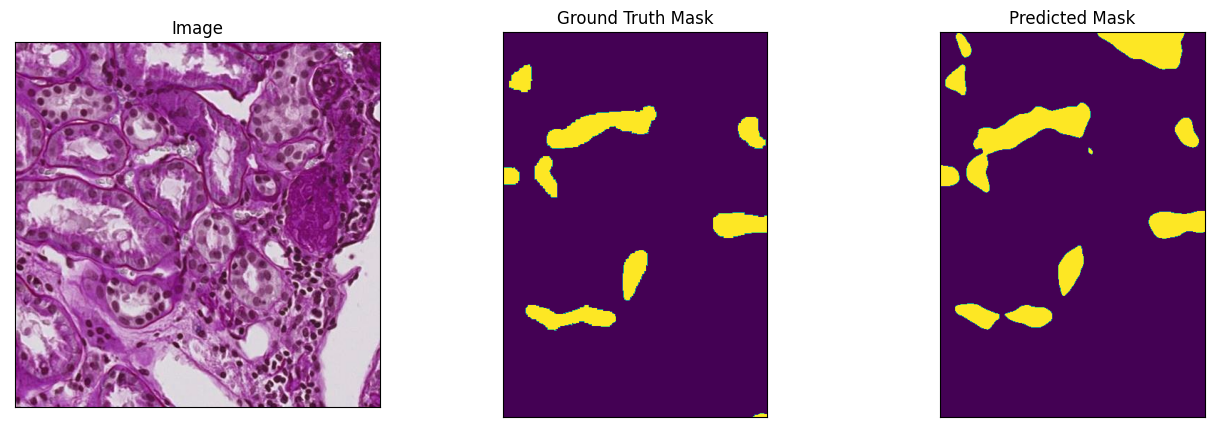

(3, 512, 352) (1, 512, 352)
torch.Size([1, 3, 512, 352])
torch.Size([1, 1, 512, 352])
(512, 352)


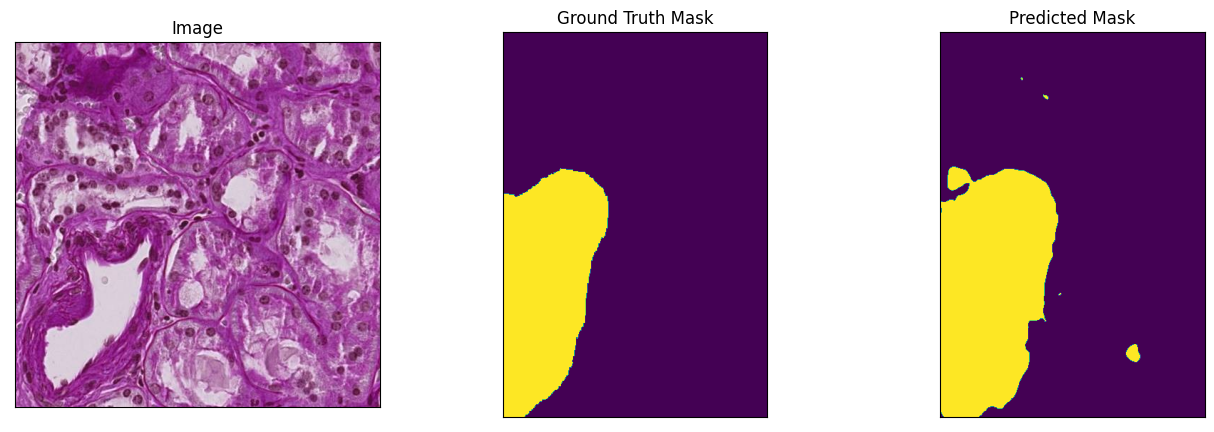

(3, 512, 352) (1, 512, 352)
torch.Size([1, 3, 512, 352])
torch.Size([1, 1, 512, 352])
(512, 352)


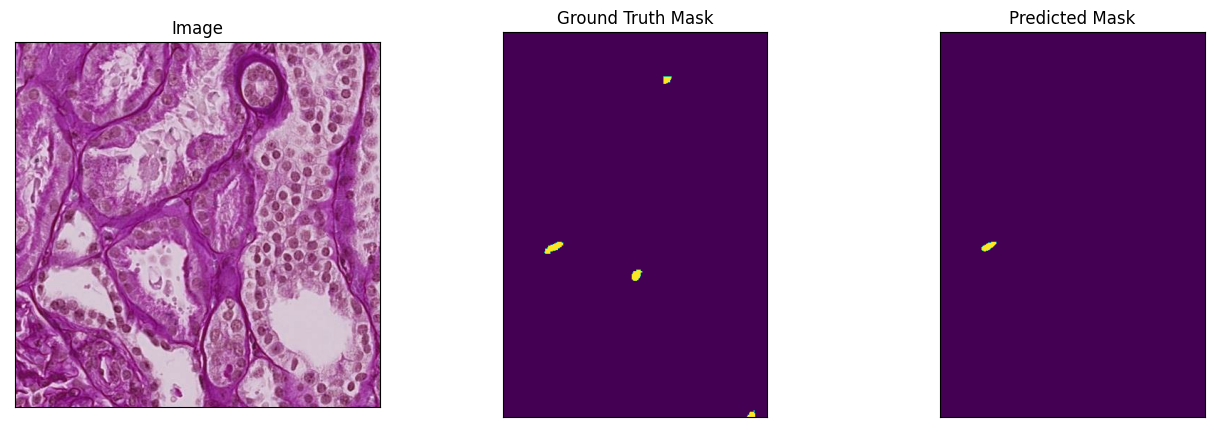

(3, 512, 352) (1, 512, 352)
torch.Size([1, 3, 512, 352])
torch.Size([1, 1, 512, 352])
(512, 352)


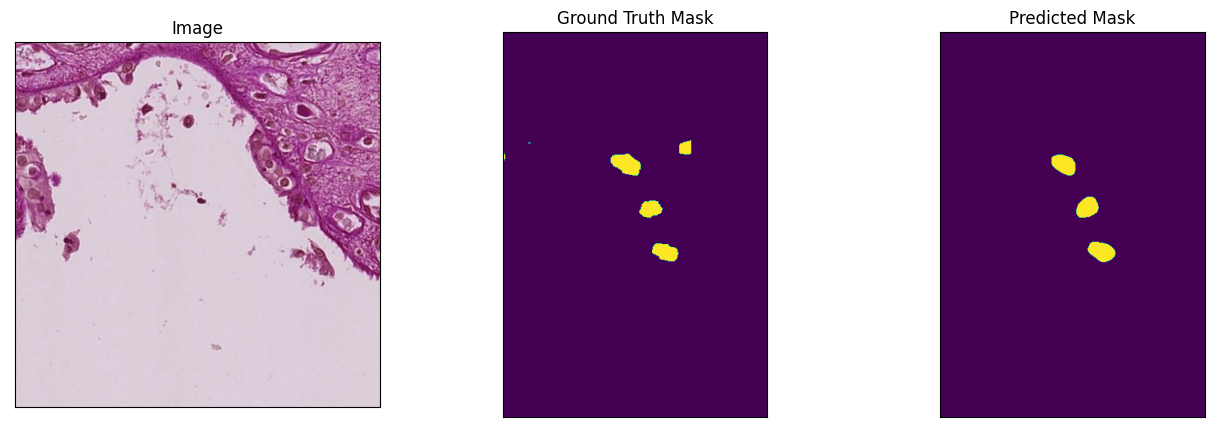

(3, 512, 352) (1, 512, 352)
torch.Size([1, 3, 512, 352])
torch.Size([1, 1, 512, 352])
(512, 352)


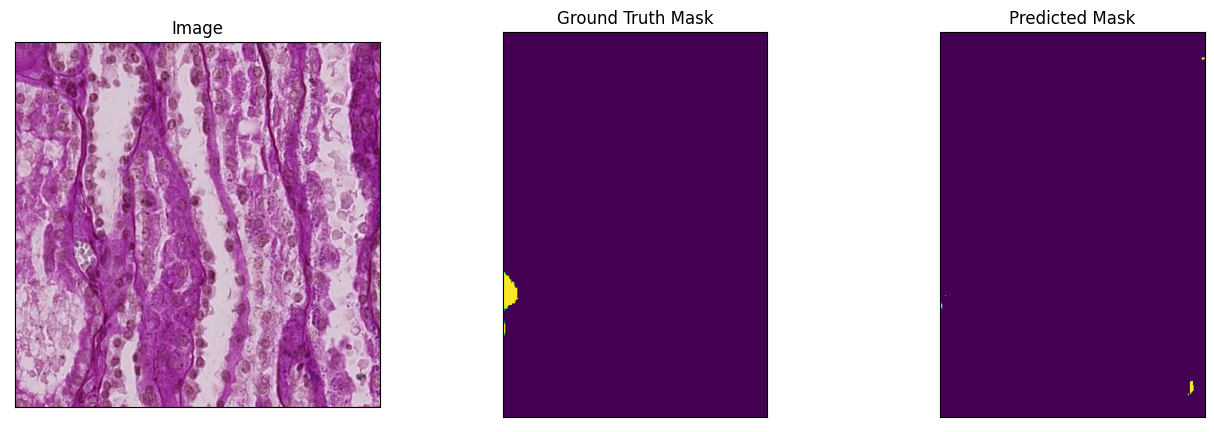

(3, 512, 352) (1, 512, 352)
torch.Size([1, 3, 512, 352])
torch.Size([1, 1, 512, 352])
(512, 352)


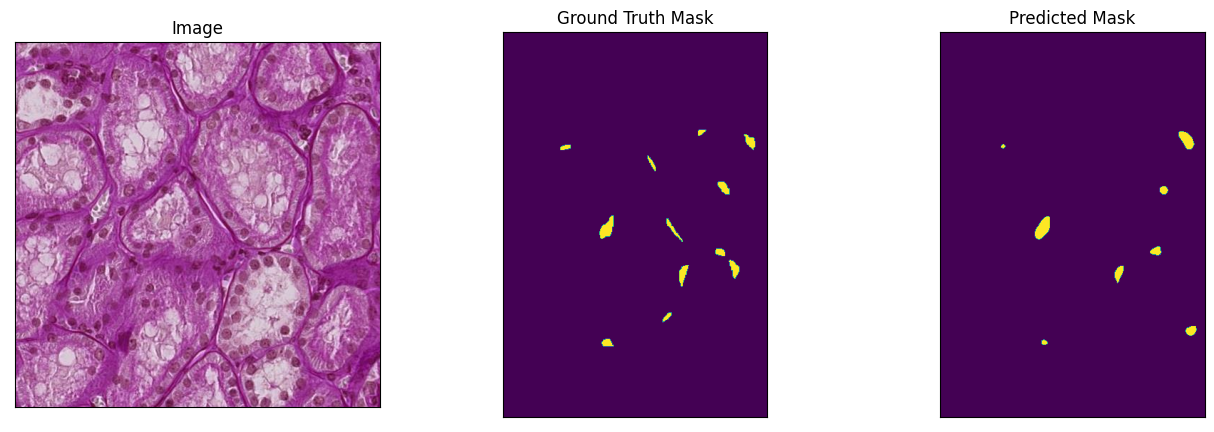

(3, 512, 352) (1, 512, 352)
torch.Size([1, 3, 512, 352])
torch.Size([1, 1, 512, 352])
(512, 352)


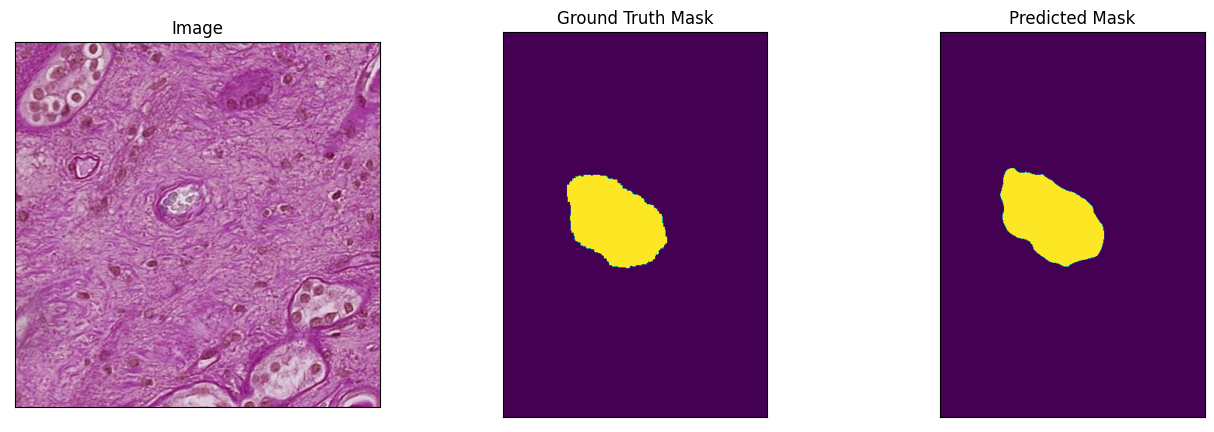

(3, 512, 352) (1, 512, 352)
torch.Size([1, 3, 512, 352])
torch.Size([1, 1, 512, 352])
(512, 352)


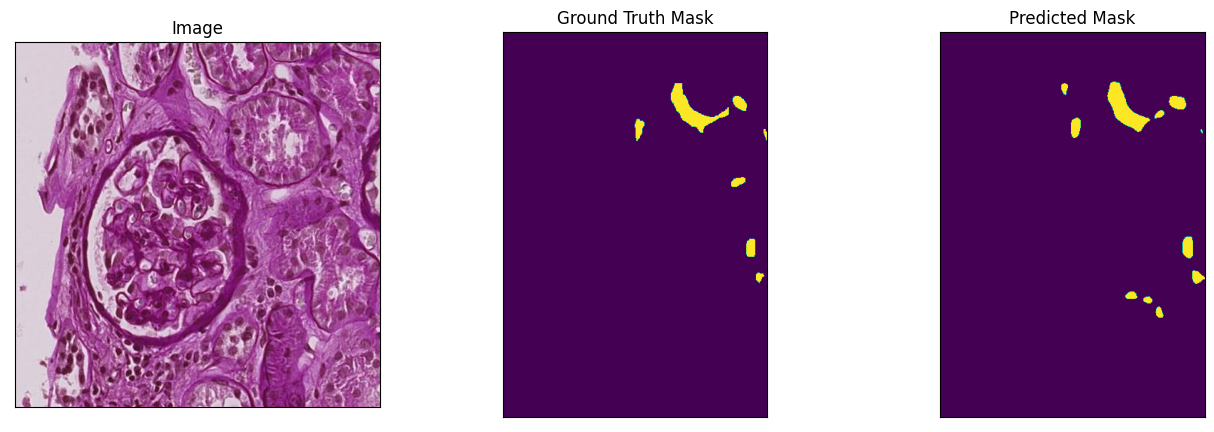

(3, 512, 352) (1, 512, 352)
torch.Size([1, 3, 512, 352])
torch.Size([1, 1, 512, 352])
(512, 352)


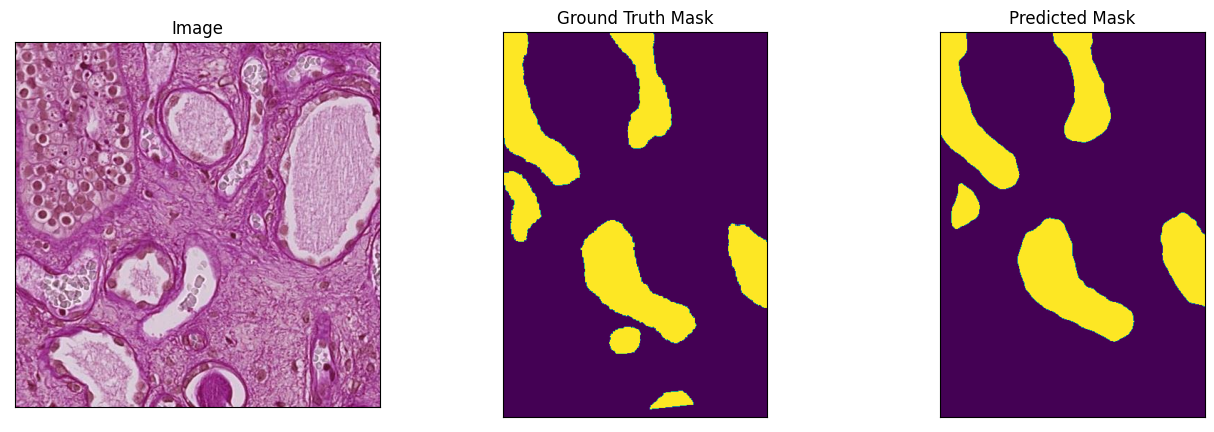

(3, 512, 352) (1, 512, 352)
torch.Size([1, 3, 512, 352])
torch.Size([1, 1, 512, 352])
(512, 352)


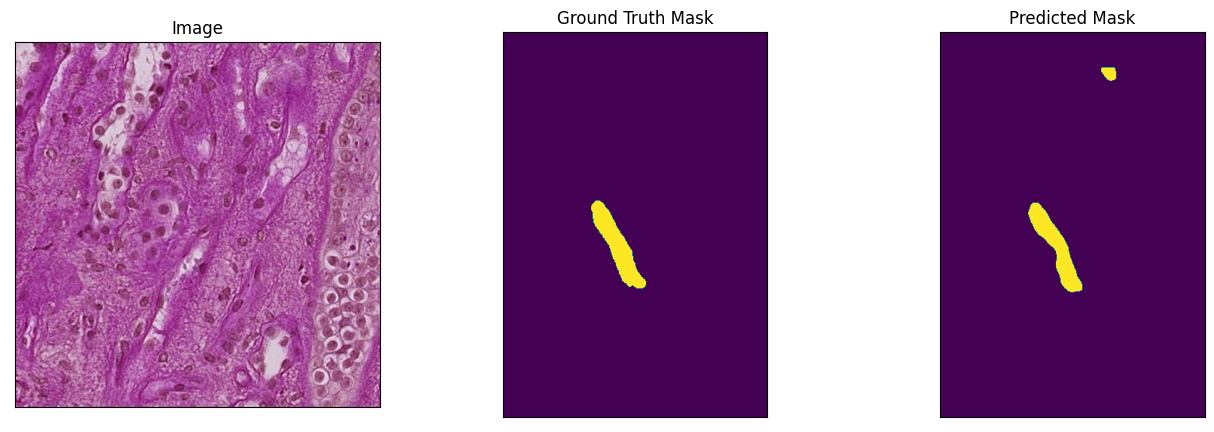

(3, 512, 352) (1, 512, 352)
torch.Size([1, 3, 512, 352])
torch.Size([1, 1, 512, 352])
(512, 352)


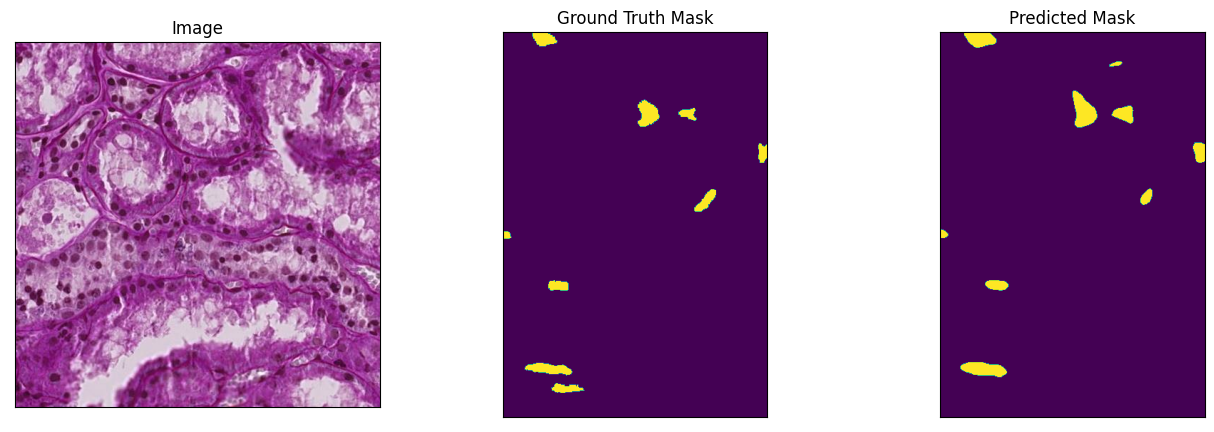

(3, 512, 352) (1, 512, 352)
torch.Size([1, 3, 512, 352])
torch.Size([1, 1, 512, 352])
(512, 352)


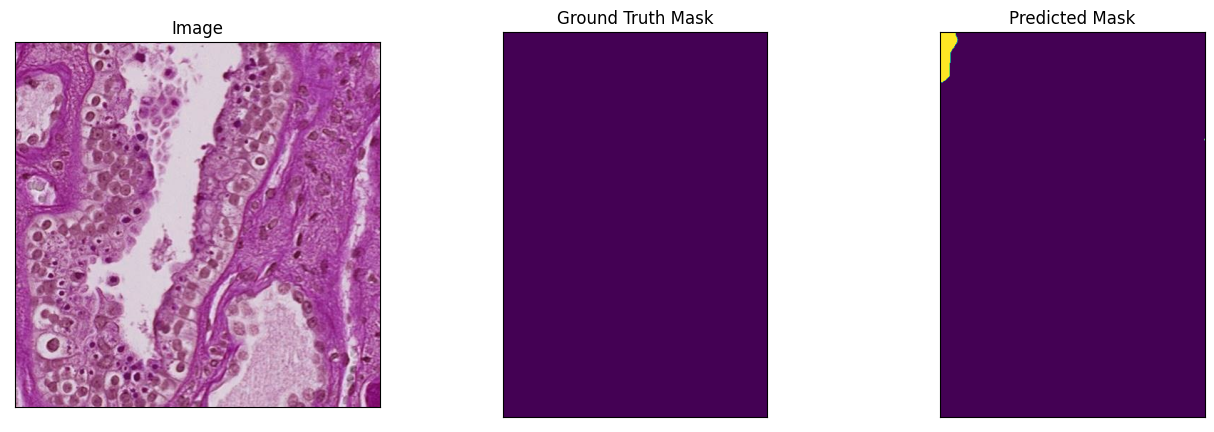

(3, 512, 352) (1, 512, 352)
torch.Size([1, 3, 512, 352])
torch.Size([1, 1, 512, 352])
(512, 352)


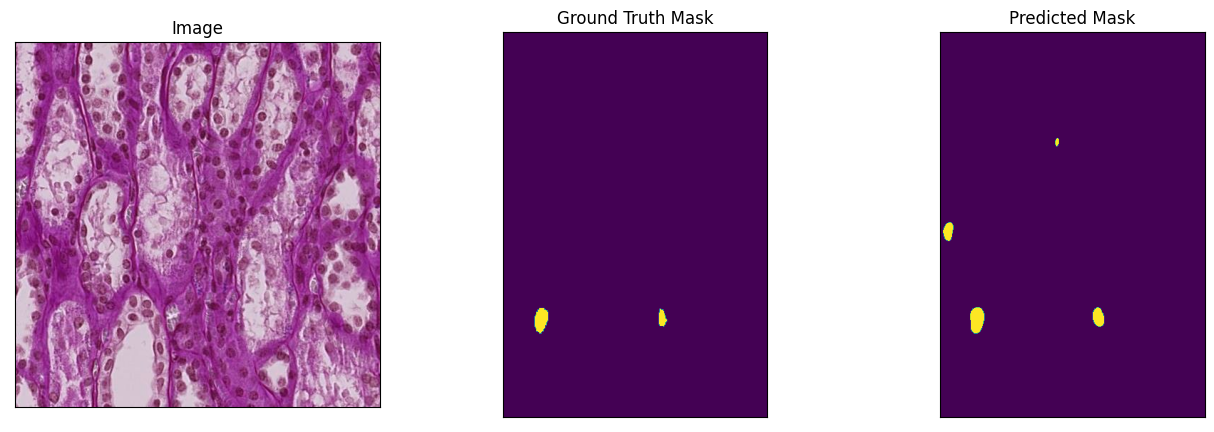

(3, 512, 352) (1, 512, 352)
torch.Size([1, 3, 512, 352])
torch.Size([1, 1, 512, 352])
(512, 352)


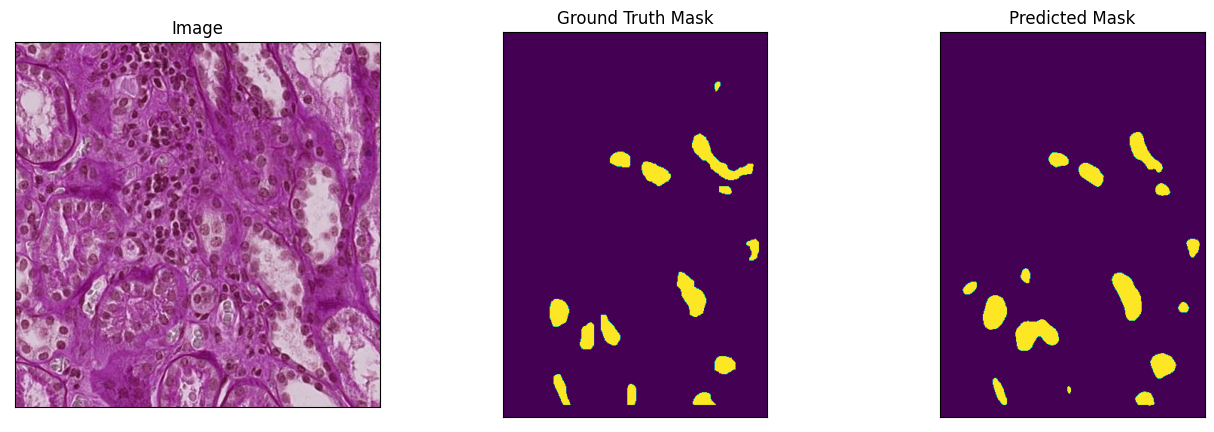

(3, 512, 352) (1, 512, 352)
torch.Size([1, 3, 512, 352])
torch.Size([1, 1, 512, 352])
(512, 352)


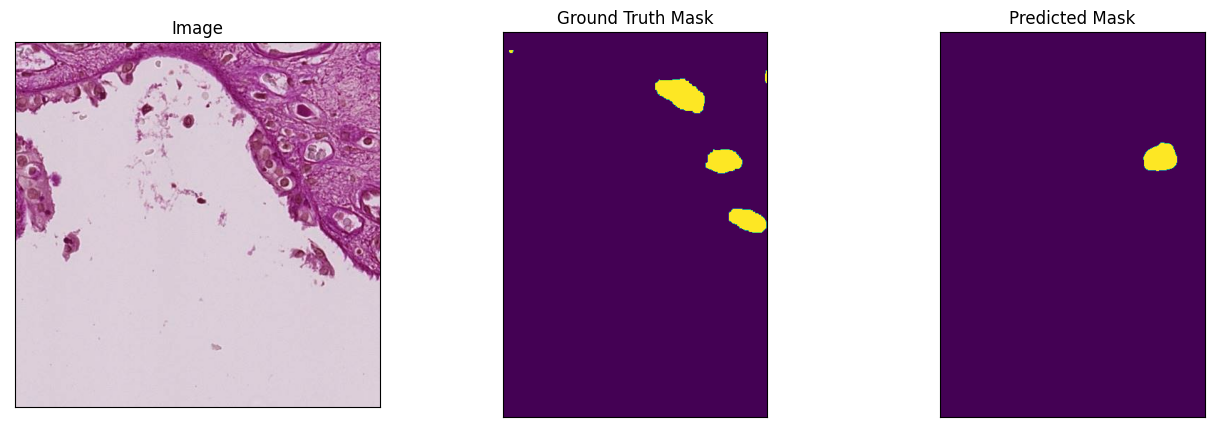

In [42]:
target_dataset = train_dataset
target_dataset_without_aug = train_dataset_without_aug
for i in range(20):
    n = np.random.choice(len(target_dataset))
    
    image_vis = target_dataset_without_aug[n][0].astype('uint8')
    image, gt_mask = target_dataset[n]
    print(image.shape, gt_mask.shape)
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    print(x_tensor.shape)
    pr_mask = torch.sigmoid(best_model.predict(x_tensor))
    print(pr_mask.shape)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    print(pr_mask.shape)
    
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )